Importing the dataset

In [ ]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [ ]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'angel'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [ ]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
# TODO
test_images = images[10000:14000]


print(train_images.shape)

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

149736 images to train on
(10000, 784)


Prepare the dataset

In [ ]:
#constract tf dataset object
train_data = tf.data.Dataset.from_tensor_slices(train_images)
test_data  = tf.data.Dataset.from_tensor_slices(test_images )

def prepare_GANS_pipeline(mnist):
  #reshape
  mnist = mnist.map(lambda img: tf.reshape(img,(28,28,1)))
  # normalize and put them into -1 to 1
  mnist = mnist.map(lambda img: tf.cast((img/128)-1,tf.float32))
  
  mnist= mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1500)
  mnist = mnist.batch(100)
  mnist = mnist.prefetch(20)
 
  return mnist

train_data = train_data.apply(prepare_GANS_pipeline)
test_data  = test_data.apply(prepare_GANS_pipeline)



# the model

### Create a class Generator:

In [ ]:
from tensorflow.keras.layers import Dense,Conv2DTranspose

# this class is same as decoder in autoencoder, so resuing it.

class MY_Generator(tf.keras.Model):
    
    def __init__(self):
        super(MY_Generator, self).__init__() 
        self.dense_1 = tf.keras.layers.Dense(7*7*256)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.reshape = tf.keras.layers.Reshape((7,7,256))
        
        self.transconv_1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(1, 1),activation=tf.nn.leaky_relu)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.transconv_2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2, 2),activation=tf.nn.leaky_relu)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
 
        self.out_Generator = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5),strides=(2, 2) , activation=tf.nn.tanh)
        
        

    @tf.function
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.batch_norm_1(x)
        x = self.reshape(x)

        x = self.transconv_1(x)
        x = self.batch_norm_2(x)
        x = self.transconv_2(x)
        x = self.batch_norm_3(x)

        
        x = self.out_Generator(x)
        return x

##### Testing

In [ ]:
inputs_generator = tf.ones((1,100))
inputs_generator.shape
model_gen = MY_Generator() 

model_gen(inputs_generator)
model_gen.summary()

Model: "my__generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  14847     
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 conv2d_transpose (Conv2DTra  multiple                 1664      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  multiple                 32832     
 ranspose)                                                       
                                                                 
 conv2d (Conv2D)             multiple                  577       
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-tra

## Discriminator


In [ ]:
from tensorflow.keras.layers import Dense,Conv2DTranspose



class MY_Discriminator(tf.keras.Model):
    
    def __init__(self):
        super(MY_Discriminator, self).__init__() 
        
        self.conv_1 = tf.keras.layers.Conv2D(filters=64,  kernel_size=(5,5), strides=(2, 2), padding = "same", activation=tf.nn.leaky_relu)
        self.drop_1 = tf.keras.layers.Dropout(0.3)
        self.conv_2 = tf.keras.layers.Conv2D(filters=128,  kernel_size=(5,5), strides=(2, 2), padding = "same", activation=tf.nn.leaky_relu)
        self.drop_2 = tf.keras.layers.Dropout(0.3)

        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2, 2), padding = "same", activation=tf.nn.leaky_relu)
        self.drop_3 = tf.keras.layers.Dropout(0.4)
 
        self.global_pool= tf.keras.layers.GlobalAvgPool2D()

        self.out_Discriminator = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)


        

    @tf.function
    def call(self, inputs):
        
        x = self.conv_1(inputs)
        x = self.drop_1(x)
        x = self.conv_2(x)
        x = self.drop_2(x)
        x = self.conv_3(x)
        x = self.drop_3(x)
        x = self.global_pool(x)
        x = self.out_Discriminator(x)

        
        return x

In [ ]:
inputs_dis = tf.ones((64,28,28,1))
inputs_generator.shape
model_dis = MY_Discriminator() 

model_dis(inputs_dis)
model_dis.summary()

Model: "my__discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  294       
                                                                 
 conv2d_1 (Conv2D)           multiple                  18848     
                                                                 
 conv2d_2 (Conv2D)           multiple                  8256      
                                                                 
 conv2d_3 (Conv2D)           multiple                  32896     
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                 

to make it noisy

In [ ]:
def train_step(generator, discriminator,real_img, gen_optimizer,dis_optimizer ):
  noise = tf.random.normal((real_img.shape[0],100))

  with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
            
            fake_data = generator(noise)
            fake_data_pred = discriminator(fake_data)
            real_data_pred = discriminator(real_img)
            
            D_loss_train = -tf.math.reduce_mean( tf.math.log(real_data_pred) + tf.math.log(1-fake_data_pred) )
            
            G_loss_train = tf.math.reduce_mean( tf.math.log(1-fake_data_pred) )
            
            
            D_gradients = D_tape.gradient(D_loss_train, discriminator.trainable_variables)
            dis_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))

            G_gradients = G_tape.gradient(G_loss_train, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
  
  return D_loss_train, G_loss_train


def test_step(generator, discriminator,real_img): 
  noise = tf.random.normal((real_img.shape[0],100))

  
            
  fake_data = generator(noise)
  fake_data_pred = discriminator(fake_data)
  real_data_pred = discriminator(real_img)
            
  D_loss_test = -tf.math.reduce_mean( tf.math.log(real_data_pred) + tf.math.log(1-fake_data_pred) )
            
  G_loss_test = tf.math.reduce_mean( tf.math.log(1-fake_data_pred) )

  return D_loss_test, G_loss_test

model training

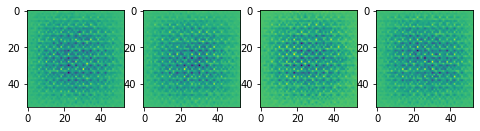

training losses: 
 gen_loss_training : -0.7576795816421509  
 dis_loss_training : 0.9377609491348267 
test losses: 
 gen_loss_test : -0.7587047815322876  
 dis_loss_test : 0.9326542615890503 


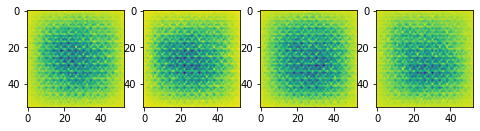

training losses: 
 gen_loss_training : -0.7748664617538452  
 dis_loss_training : 0.8686894178390503 
test losses: 
 gen_loss_test : -0.7744495868682861  
 dis_loss_test : 0.8679943680763245 


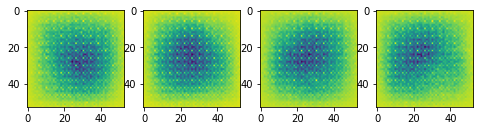

training losses: 
 gen_loss_training : -0.6310701370239258  
 dis_loss_training : 0.7269838452339172 
test losses: 
 gen_loss_test : -0.6309749484062195  
 dis_loss_test : 0.7154614925384521 


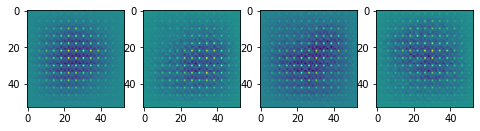

training losses: 
 gen_loss_training : -0.510417103767395  
 dis_loss_training : 0.5556471943855286 
test losses: 
 gen_loss_test : -0.5089262127876282  
 dis_loss_test : 0.5525854229927063 


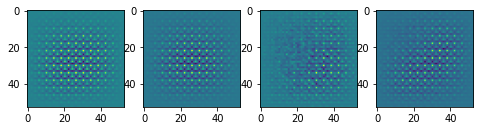

training losses: 
 gen_loss_training : -0.5139241218566895  
 dis_loss_training : 0.5380455851554871 
test losses: 
 gen_loss_test : -0.5109004974365234  
 dis_loss_test : 0.526872992515564 


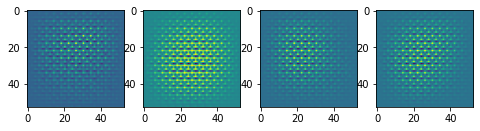

training losses: 
 gen_loss_training : -0.6114234924316406  
 dis_loss_training : 0.6155053377151489 
test losses: 
 gen_loss_test : -0.6168786883354187  
 dis_loss_test : 0.6207618117332458 


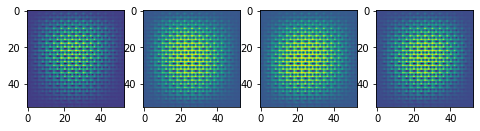

training losses: 
 gen_loss_training : -0.48464104533195496  
 dis_loss_training : 0.48590365052223206 
test losses: 
 gen_loss_test : -0.48288822174072266  
 dis_loss_test : 0.484058678150177 


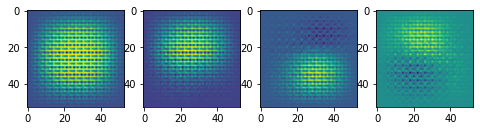

training losses: 
 gen_loss_training : -0.5899842977523804  
 dis_loss_training : 0.6093601584434509 
test losses: 
 gen_loss_test : -0.5262933373451233  
 dis_loss_test : 0.545479953289032 


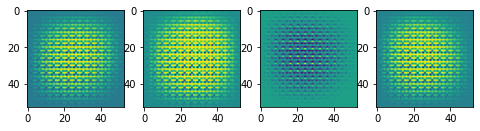

training losses: 
 gen_loss_training : -0.5334208607673645  
 dis_loss_training : 0.5832059383392334 
test losses: 
 gen_loss_test : -0.4984504282474518  
 dis_loss_test : 0.5487404465675354 


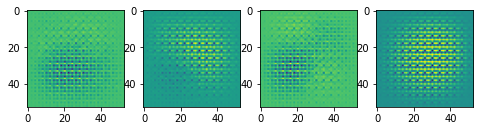

training losses: 
 gen_loss_training : -0.29627326130867004  
 dis_loss_training : 0.3409518003463745 
test losses: 
 gen_loss_test : -0.23701325058937073  
 dis_loss_test : 0.2720261812210083 


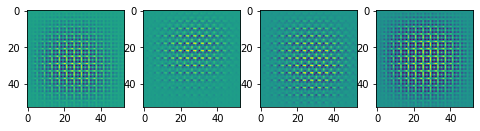

training losses: 
 gen_loss_training : -0.1400528997182846  
 dis_loss_training : 0.14971782267093658 
test losses: 
 gen_loss_test : -0.15011560916900635  
 dis_loss_test : 0.16053122282028198 


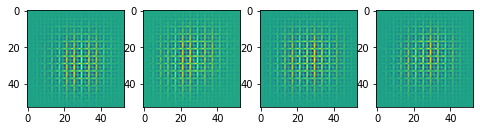

training losses: 
 gen_loss_training : -0.09766579419374466  
 dis_loss_training : 0.1019035056233406 
test losses: 
 gen_loss_test : -0.10445208847522736  
 dis_loss_test : 0.10880817472934723 


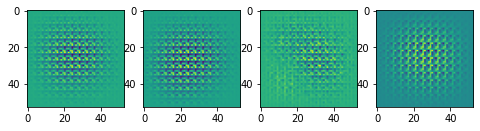

training losses: 
 gen_loss_training : -0.11318659037351608  
 dis_loss_training : 0.1153392568230629 
test losses: 
 gen_loss_test : -0.15612763166427612  
 dis_loss_test : 0.1581822633743286 


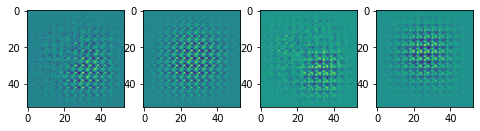

training losses: 
 gen_loss_training : -0.10687016695737839  
 dis_loss_training : 0.11400994658470154 
test losses: 
 gen_loss_test : -0.11300106346607208  
 dis_loss_test : 0.1225445494055748 


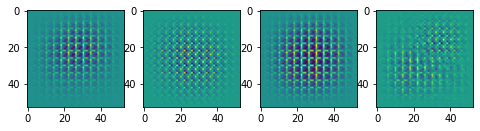

training losses: 
 gen_loss_training : -0.047410041093826294  
 dis_loss_training : 0.057952698320150375 
test losses: 
 gen_loss_test : -0.048373088240623474  
 dis_loss_test : 0.058256376534700394 


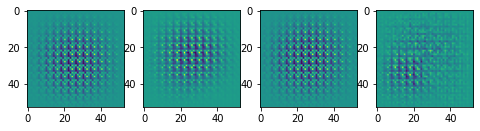

training losses: 
 gen_loss_training : -0.018004722893238068  
 dis_loss_training : 0.021758463233709335 
test losses: 
 gen_loss_test : -0.016545897349715233  
 dis_loss_test : 0.05468931049108505 


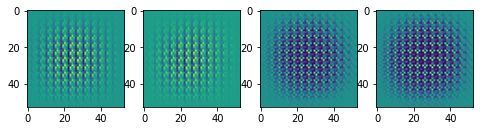

training losses: 
 gen_loss_training : -0.005330726038664579  
 dis_loss_training : 0.006185677833855152 
test losses: 
 gen_loss_test : -0.005650597624480724  
 dis_loss_test : 0.009670215658843517 


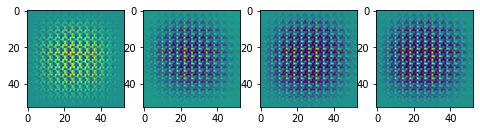

training losses: 
 gen_loss_training : -0.0029694067779928446  
 dis_loss_training : 0.0031845164485275745 
test losses: 
 gen_loss_test : -0.003061107126995921  
 dis_loss_test : 0.0036306336987763643 


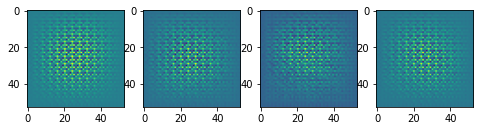

training losses: 
 gen_loss_training : -0.0020050143357366323  
 dis_loss_training : 0.0023395128082484007 
test losses: 
 gen_loss_test : -0.0015832160133868456  
 dis_loss_test : 0.002040102379396558 


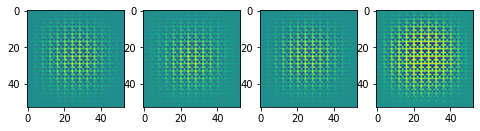

training losses: 
 gen_loss_training : -0.0008153467788361013  
 dis_loss_training : 0.001035018009133637 
test losses: 
 gen_loss_test : -0.0006243840325623751  
 dis_loss_test : 0.0008696853183209896 


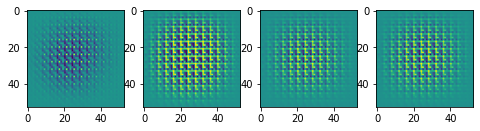

training losses: 
 gen_loss_training : -0.0002987705229315907  
 dis_loss_training : 0.00033407987211830914 
test losses: 
 gen_loss_test : -0.00032151798950508237  
 dis_loss_test : 0.0003859667049255222 


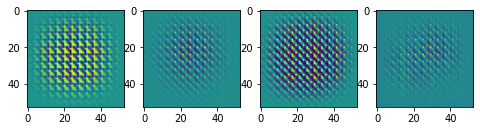

training losses: 
 gen_loss_training : -9.685692202765495e-05  
 dis_loss_training : 0.00013740711438003927 
test losses: 
 gen_loss_test : -8.827490091789514e-05  
 dis_loss_test : 0.00011433717008912936 


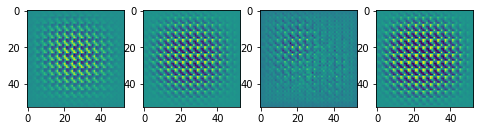

training losses: 
 gen_loss_training : -5.005278580938466e-05  
 dis_loss_training : 6.473692337749526e-05 
test losses: 
 gen_loss_test : -4.4434895244194195e-05  
 dis_loss_test : 5.633777618641034e-05 


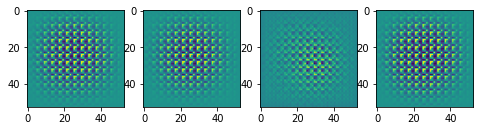

training losses: 
 gen_loss_training : -2.1001558707212098e-05  
 dis_loss_training : 2.566985131124966e-05 
test losses: 
 gen_loss_test : -2.209122249041684e-05  
 dis_loss_test : 3.66576095984783e-05 


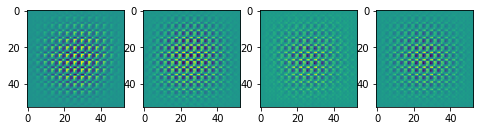

training losses: 
 gen_loss_training : -9.527918336971197e-06  
 dis_loss_training : 1.1026400898117572e-05 
test losses: 
 gen_loss_test : -9.369356121169403e-06  
 dis_loss_test : 1.0015472071245313e-05 


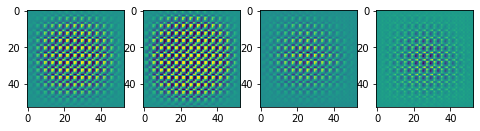

training losses: 
 gen_loss_training : -1.8376144907961134e-06  
 dis_loss_training : 3.4934917039208813e-06 
test losses: 
 gen_loss_test : -1.9335795968800085e-06  
 dis_loss_test : 2.309089268237585e-06 


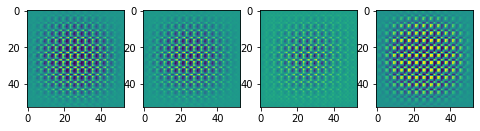

training losses: 
 gen_loss_training : -4.810097493646026e-07  
 dis_loss_training : 5.286934765535989e-07 
test losses: 
 gen_loss_test : -4.1484855728413095e-07  
 dis_loss_test : 6.985673621784372e-07 


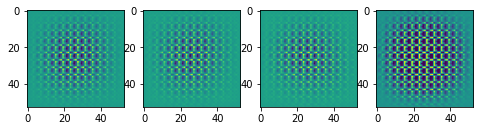

training losses: 
 gen_loss_training : -3.057719766275113e-07  
 dis_loss_training : 3.701451021242974e-07 
test losses: 
 gen_loss_test : -1.883507110278515e-07  
 dis_loss_test : 1.9907955106646114e-07 


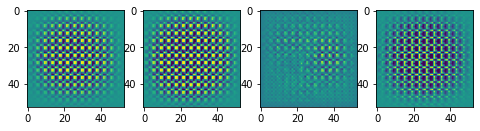

training losses: 
 gen_loss_training : -1.0192395905050944e-07  
 dis_loss_training : 1.0430814967321567e-07 
test losses: 
 gen_loss_test : -1.1146070733047964e-07  
 dis_loss_test : 1.3768676865311136e-07 


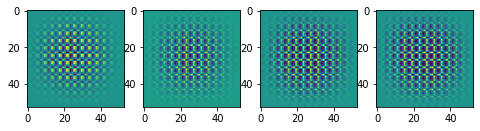

training losses: 
 gen_loss_training : -2.980232594040899e-08  
 dis_loss_training : 3.0994421251762105e-08 
test losses: 
 gen_loss_test : -1.2516975012033527e-08  
 dis_loss_test : 2.9206278284732434e-08 


In [ ]:
generator = MY_Generator()
discriminator = MY_Discriminator()

epochs = 30

dis_losses_train = []

gen_losses_train = []

dis_losses_test = []

gen_losses_test = []


learning_rate = 0.00001
dis_optimizer = tf.keras.optimizers.RMSprop(learning_rate)

gen_optimizer = tf.keras.optimizers.RMSprop(learning_rate)

for epoc in range(epochs):

  for real_img in train_data: 
    # return D_loss , G_loss  def train_step(generator, discriminator,real_img, gen_optimizer,dis_optimizer ):
    d_loss_train,g_loss_train = train_step( generator,discriminator, real_img, gen_optimizer,dis_optimizer)
    dis_losses_train.append([tf.reduce_mean(d_loss_train)])
    gen_losses_train.append([tf.reduce_mean(g_loss_train)])


  # def test_step(generator, discriminator,real_img): 
  for real_img in test_data: 
    d_loss_test, g_loss_test = test_step( generator, discriminator, real_img)
    dis_losses_test.append([tf.reduce_mean(d_loss_test)])
    gen_losses_test.append([tf.reduce_mean(g_loss_test)])

  visualize(generator)
  print(f"training losses: \n gen_loss_training : {gen_losses_train[-1][-1]}  \n dis_loss_training : {dis_losses_train[-1][-1]} ")
  print(f"test losses: \n gen_loss_test : {gen_losses_test[-1][-1]}  \n dis_loss_test : {dis_losses_test[-1][-1]} ")


In [ ]:
  def visualize(gen, img_num=4):
    
    noise = tf.random.normal((4, 100))
    images = gen(noise).numpy()
    
    fig = plt.figure(figsize=(8, 8))

    for i in range(1, img_num+1):
        fig.add_subplot(1, img_num, i)
        plt.imshow(tf.squeeze(images[i-1]))
        
    plt.show()